In [6]:
import torch  
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import numpy as np  
import matplotlib.pyplot as plt

from mesh import *
from utils import *
from bf import *
from condition import *

from torch import tensor as Tensor
from torch import matmul as matmul

tensor([-0.8124,  0.0823], grad_fn=<AddBackward0>)
tensor([[0.0525]], grad_fn=<AddmmBackward0>)


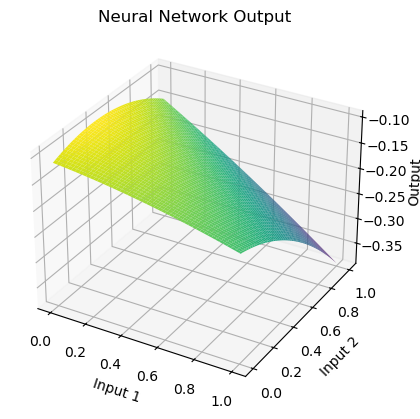

In [1]:
import torch  
import torch.nn as nn  
import matplotlib.pyplot as plt  
from mpl_toolkits.mplot3d import Axes3D  
import numpy as np   
    
class basisref(nn.Module):
    # nn model based on reference cell
    def __init__(self):
        super(basisref, self).__init__()
        self.fc1 = nn.Linear(5, 10) 
        self.fc2 = nn.Linear(10, 1)
    def forward(self, p):
        '''p must be torch.tensor and requires_grad=True, dtype=torch.float32'''
        # print(p)
        x = p[0:1]; y = p[1:2]
        input = torch.stack([x, y, x*y, x**2, y**2], dim=-1)
        o1 = self.fc1(input)
        phi = self.fc2(o1)
        return phi


def plot():
    # 创建神经`网络实例  
    input_size = 2  
    hidden_size1 = 3  
    hidden_size2 = 4  
    output_size = 1  
    # model = basisref(input_size, hidden_size1, hidden_size2, output_size)  
    model = basisref()
    
    # 生成网格点  
    x_values = np.linspace(0, 1, 100)  
    y_values = np.linspace(0, 1, 100)  
    X, Y = np.meshgrid(x_values, y_values)  
    inputs = np.c_[X.ravel(), Y.ravel()]  
    # print(inputs, "X", X, "Y", Y)
    
    # 将输入转换为张量  
    inputs = torch.tensor(inputs, dtype=torch.float)  

    
    # 运行前向传播  
    outputs = np.zeros(inputs.shape[0])
    with torch.no_grad():  
        for i in range(inputs.shape[0]):
            outputs[i] = model(inputs[i])
    outputs = outputs.reshape(X.shape)  
    # 绘制3D图形  
    fig = plt.figure()  
    ax = fig.add_subplot(111, projection='3d')  
    ax.plot_surface(X, Y, outputs, cmap='viridis')  
    
    ax.set_xlabel('Input 1')  
    ax.set_ylabel('Input 2')  
    ax.set_zlabel('Output')  
    ax.set_title('Neural Network Output')  
    
    plt.show() 

def ma():
    model = basisref()
    p = torch.tensor([1.0, 2.0], requires_grad=True, dtype=torch.float32)  
  
    # 前向传播  
    output = model(p)  
    gd = torch.autograd.grad(output, p, create_graph=True, retain_graph=True, allow_unused=True)[0]
    print(gd)
    print(output)

ma()
plot()

Epoch [1/1000], Loss: 0.1562
Epoch [101/1000], Loss: 0.0255
Epoch [201/1000], Loss: 0.0218
Epoch [301/1000], Loss: 0.0193
Epoch [401/1000], Loss: 0.0172
Epoch [501/1000], Loss: 0.0155
Epoch [601/1000], Loss: 0.0139
Epoch [701/1000], Loss: 0.0125
Epoch [801/1000], Loss: 0.0114
Epoch [901/1000], Loss: 0.0103
Epoch [1001/1000], Loss: 0.0094
Epoch [1101/1000], Loss: 0.0087
Epoch [1201/1000], Loss: 0.0081
Epoch [1301/1000], Loss: 0.0075
Epoch [1401/1000], Loss: 0.0071
Epoch [1501/1000], Loss: 0.0067
Epoch [1601/1000], Loss: 0.0064
Epoch [1701/1000], Loss: 0.0061
Epoch [1801/1000], Loss: 0.0059
Epoch [1901/1000], Loss: 0.0057
Epoch [2001/1000], Loss: 0.0055
Epoch [2101/1000], Loss: 0.0054
Epoch [2201/1000], Loss: 0.0053
Epoch [2301/1000], Loss: 0.0051
Epoch [2401/1000], Loss: 0.0050
Epoch [2501/1000], Loss: 0.0049
Epoch [2601/1000], Loss: 0.0049
Epoch [2701/1000], Loss: 0.0048
Epoch [2801/1000], Loss: 0.0047
Epoch [2901/1000], Loss: 0.0047
Epoch [3001/1000], Loss: 0.0046
Epoch [3101/1000], L

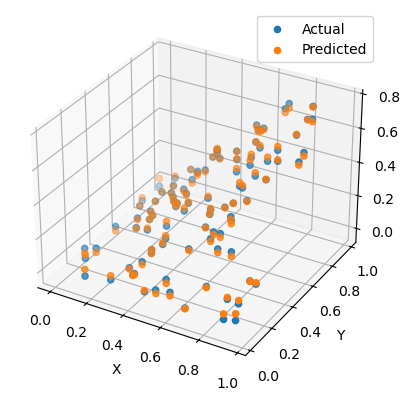

# Method1 DGNet

In [29]:
def totensor(n):
    return Tensor(n, dtype=torch.float32)

def intE(bflist, k, i):
    '''
    integral of $\nabla u \nabla v$ on kth element E
    ith test function
    '''
    w = Tensor([1.0/6, 1.0/6, 1.0/6])
    points = [[2.0/3, 1.0/6], [1.0/6, 1.0/6], [1.0/6, 2.0/3]]
    NG = w.shape[0]
    
    T = Tensor(0.0)
    F = Tensor(0.0)

    E = meshelt[k]
    bf = bflist[k]
    p1 = meshvertex[E.vertex[0]]; p2 = meshvertex[E.vertex[1]]; p3 = meshvertex[E.vertex[2]]

    BE, bE = computeBE(p1, p2, p3)
    invBE = torch.inverse(BE).t()
    detBE = torch.det(BE)
    
    for m in range(NG):
        p = Tensor(points[m], requires_grad=True)
        phii = phi.get(i)(p)
        gphii = grad_phi.get(i)(p)
        realcor = hat2E(BE, bE, p)
        # print('ok')
        f = source(realcor)
        u = bf(p)
        u.backward()
        gbf = p.grad
        T += detBE * w[m] * torch.dot(matmul(invBE, gbf), matmul(invBE, gphii))
        F += w[m] * detBE * f * phii

    return T, F
            

################################################################################################################
def normvec(e: face):
    '''norm vector from E1 point to E2'''
    p1 = meshvertex[e.vertex[0]]; p2 = meshvertex[e.vertex[1]]
    v0 = p2 - p1
    if e.bctype == 0:
        E1 = meshelt[e.neighbor[0]]; E2 = meshelt[e.neighbor[1]]
        # print(e.neighbor[0], e.neighbor[1])
        inx = np.array([e.vertex[0], e.vertex[1]])
        n1 = E1.vertex[~np.isin(E1.vertex, inx)][0]
        n2 = E2.vertex[~np.isin(E2.vertex, inx)][0]
        # print(n1, n2)
        v1 = meshvertex[n2] - meshvertex[n1]
        tmpvec = np.array([-v0[1], v0[0]])
        t = np.dot(v1, tmpvec)
        if t > -1e-10:
            return totensor(tmpvec / np.linalg.norm(tmpvec))
        else:
            return totensor(-tmpvec / np.linalg.norm(tmpvec))
    elif e.bctype == 1:
        E1 = meshelt[e.neighbor[0]]
        inx = np.array([e.vertex[0], e.vertex[1]])
        n1 = E1.vertex[~np.isin(E1.vertex, inx)][0]
        v1 = meshvertex[n1] - p1
        tmpvec = np.array([-v0[1], v0[0]])
        t = np.dot(v1, tmpvec)
        if t > -1e-10:
            return totensor(-tmpvec / np.linalg.norm(tmpvec))
            
        else:
            return totensor(tmpvec / np.linalg.norm(tmpvec))

##################################################################################################
def inte(bflist, noe, notf):
    '''
    intergral of functions on neighbour cell E of edge e 
    '''
    e = meshface[noe]
    p1 = meshvertex[e.vertex[0]]; p2 = meshvertex[e.vertex[1]]
    leng = length(p1, p2)
    nvec = normvec(e)
    s = [-0.86113631, -0.33998104, 0.33998104, 0.86113631]
    w = Tensor([0.17392742, 0.32607257, 0.32607257, 0.17392742])
    NG = w.shape[0]
    A = Tensor(0.0)
    S = Tensor(0.0)
    J = Tensor(0.0)
    D = Tensor(0.0)
    
    if e.bctype == 0:
        n1 = e.neighbor[0]; n2 = e.neighbor[1]
        E1 = meshelt[n1]; E2 = meshelt[n2]
        BE1, bE1 = computeBE(meshvertex[E1.vertex[0]], meshvertex[E1.vertex[1]], meshvertex[E1.vertex[2]])
        BE2, bE2 = computeBE(meshvertex[E2.vertex[0]], meshvertex[E2.vertex[1]], meshvertex[E2.vertex[2]])
        invBE1 = torch.inverse(BE1).t()
        invBE2 = torch.inverse(BE2).t()
        # print(n1, n2)
        bf1 = bflist[n1]; bf2 = bflist[n2]

        for k in range(NG):
            realcor = ref2I(p1, p2, s[k])
            refcorE1 = E2hat(BE1, bE1, realcor)
            refcorE2 = E2hat(BE2, bE2, realcor)

            phi1 = phi.get(notf)(refcorE1)
            gphi1 = grad_phi.get(notf)(refcorE1)
            phi2 = phi.get(notf)(refcorE2)
            gphi2 = grad_phi.get(notf)(refcorE2)
            

            tp1 = refcorE1.clone().requires_grad_(True)
            tp2 = refcorE2.clone().requires_grad_(True)

            u1 = bf1(tp1); u2 = bf2(tp2)
            u1.backward(); gu1 = tp1.grad
            u2.backward(); gu2 = tp2.grad
            jump = u1.item() - u2.item()

            A -= 0.5 * w[k] * leng * torch.dot(matmul(invBE1, gu1)+matmul(invBE2, gu2), nvec) * (phi1 - phi2)
            S += eps * 0.5 * leng * torch.dot(matmul(invBE1, gphi1)+matmul(invBE2, gphi2), nvec) * jump
            J += sigma * leng * jump * (phi1 - phi2)
        return A, S, J
    elif e.bctype == 1:
        n = e.neighbor[0]
        E = meshelt[n]
        BE, bE = computeBE(meshvertex[E.vertex[0]], meshvertex[E.vertex[1]], meshvertex[E.vertex[2]])
        invBE = torch.inverse(BE).t()
        bf = bflist[n]

        for k in range(NG):
            realcor = ref2I(p1, p2, s[k])
            refcorE = E2hat(BE, bE, realcor)
            
            phi1 = phi.get(notf)(refcorE)
            gphi1 = grad_phi.get(notf)(refcorE)

            tp = refcorE.clone().requires_grad_(True)
            u = bf(tp); u.backward(); gu = tp.grad
            A -= w[k] * leng * torch.dot(matmul(invBE, gu), nvec) * phi1
            S += eps * w[k] * leng * torch.dot(matmul(invBE, gphi1), nvec) * u.item()
            J += sigma * u.item() * phi1
            D += w[k] * (leng * eps * torch.dot(matmul(invBE, gphi1), nvec) + sigma * phi1) * dirichlet(realcor)
        return A, S, J, D


def trainplug(bflist):
    for i in range(Nelt):
        bflist[i].train()
def evalplug(bflist):
    for i in range(Nelt):
        bflist[i].eval()
def aggpara(bflist):
    parameters = []
    for i in range(Nelt):
        parameters += list(bflist[i].parameters())
    return parameters
# aggpara()

In [52]:
class DGNet:
    def __init__(self) -> None:
        bflist = [] # basis function list
        for _ in range(Nelt):
            bf = basisref()
            bflist.append(bf)
        self.models = bflist
        self.parameters = aggpara(self.models)
        self.optimizer = torch.optim.LBFGS(self.parameters, lr=1.0, max_iter=50000, max_eval=50000, history_size=50, 
                                           tolerance_grad=1e-7, tolerance_change=1.0 * np.finfo(float).eps, line_search_fn='strong_wolfe')
        self.adam = torch.optim.Adam(self.parameters, lr=0.001, betas=(0.9, 0.999), eps=1e-8)
        self.iter = 1
        self.criterion = nn.MSELoss() 
    def lossfunc(self):
        self.adam.zero_grad()
        loss = Tensor(0.0)
        for i in range(Nloc):
            for k in range(Nelt):
                A, B = intE(self.models, k ,i)
                loss += A - B
            for k in range(Nface):
                if meshface[k].bctype == 0:
                    C, S, J = inte(self.models, k, i)
                    # print('CSJ', C, S, J)
                    loss += C + S + J
                elif meshface[k].bctype == 1:
                    C, S, J, D = inte(self.models, k, i)
                    # print('CSJD', C, S, J, D)
                    loss += C + S + J - D
        print(loss)
        loss = loss ** 2
        loss.backward()
        if self.iter % 1 == 0:
            print(self.iter, loss.item())
        self.iter += 1
        return loss
    
    def train(self):
        trainplug(self.models)
        for i in range(10):
            self.adam.step(self.lossfunc)
        self.optimizer.step(self.lossfunc)

    def eval(self):
        evalplug(self.models)

model = DGNet()
model.train()

tensor(-15.3153, grad_fn=<AddBackward0>)
1 234.55873107910156
tensor(-26.4039, grad_fn=<AddBackward0>)
2 697.1650390625
tensor(-37.3983, grad_fn=<AddBackward0>)
3 1398.635986328125
tensor(-48.5171, grad_fn=<AddBackward0>)
4 2353.912841796875
tensor(-59.6365, grad_fn=<AddBackward0>)
5 3556.51171875
tensor(-70.7456, grad_fn=<AddBackward0>)
6 5004.939453125
tensor(-81.8715, grad_fn=<AddBackward0>)
7 6702.93603515625
tensor(-93.0097, grad_fn=<AddBackward0>)
8 8650.8125
tensor(-104.1510, grad_fn=<AddBackward0>)
9 10847.4326171875
tensor(-115.2837, grad_fn=<AddBackward0>)
10 13290.3203125
tensor(-126.3511, grad_fn=<AddBackward0>)
11 15964.6015625
tensor(-183.6078, grad_fn=<AddBackward0>)
12 33711.8359375
tensor(-126.3683, grad_fn=<AddBackward0>)
13 15968.95703125
tensor(-126.3528, grad_fn=<AddBackward0>)
14 15965.029296875
tensor(-126.3511, grad_fn=<AddBackward0>)
15 15964.6015625


/tmp/ipykernel_286915/2136042464.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  refcor = torch.tensor(refcor, dtype=torch.float32)


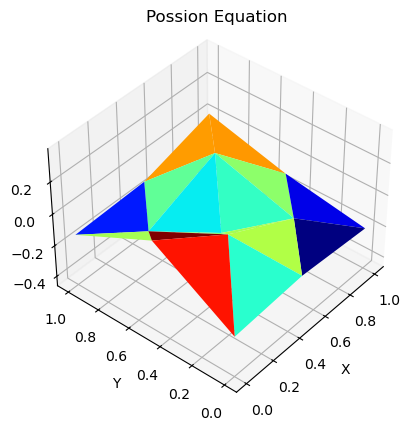

In [53]:
def basisphy(bflist, k, p):
    # p is real coordinates, function on real physical domain
    E = meshelt[k]
    p1 = meshvertex[E.vertex[0]]; p2 = meshvertex[E.vertex[1]]; p3 = meshvertex[E.vertex[2]]
    BE, bE = computeBE(p1, p2, p3)
    refcor = E2hat(BE, bE, p)
    if is_in_ref(refcor) != -1:
        refcor = torch.tensor(refcor, dtype=torch.float32)
        return bflist[k](refcor)
    else:
        print("outside")
        return 0

def plot3D(): 
    fig = plt.figure()    
    n_inter = 2
    p_inter = totensor(sample_triangle(n_inter))
    N_inter = p_inter.shape[0]
    N_tol = Nelt * N_inter
    sol = torch.zeros(N_tol)
    plot_p = torch.zeros((N_tol, 2))
    for i in range(Nelt):
        for j in range(N_inter):
            n1 = Mesh[i][0]; n2 = Mesh[i][1]; n3 = Mesh[i][2]
            p1 = meshvertex[n1]; p2 = meshvertex[n2]; p3 = meshvertex[n3]; 
            BE, bE = computeBE(p1, p2, p3)
            ie = i * N_inter + j
            real_p = hat2E(BE, bE, p_inter[j])

            sol[ie] = basisphy(model.models,i, real_p)
            plot_p[ie] = real_p
    plot_p = plot_p.detach().numpy()  
    sol = sol.detach().numpy()  
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=40, azim=220)
    ax.plot_trisurf(plot_p[:, 0], plot_p[:, 1], sol, cmap='jet')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Possion Equation')
    plt.show()
plot3D()

# Mehod2 GraphDG


In [3]:
import torch 
from torch_geometric.data import Data
device = 'cuda' if torch.cuda.is_available() else 'cpu'
############################################# generate graoh by mesh #################################################
neighlist = []
for i in range(Nface):
    e = meshface[i]
    if e.bctype == 0:
        neighlist.append(e.neighbor)
neighlist = Tensor(neighlist)

data = Data(x=meshelt, edge_index=neighlist.contiguous())
print(data['x'][0].vertex)

[ 4 12  9]


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定义多个网络
net1 = nn.Linear(10, 5)
net2 = nn.Linear(5, 3)

# 将参数合并到一个列表中
parameters = list(net1.parameters()) + list(net2.parameters())

print(parameters, 'jjjj', net1.parameters())
# 创建Adam优化器并传入参数列表
optimizer = optim.Adam(parameters, lr=0.001)

# 使用优化器进行参数更新
optimizer.step()


[Parameter containing:
tensor([[-0.2845,  0.1276, -0.1388,  0.2833, -0.2262,  0.1838, -0.0422,  0.2975,
          0.0970,  0.2521],
        [-0.1721,  0.1070,  0.2469, -0.1655,  0.2981,  0.1439, -0.1894,  0.1480,
          0.0071,  0.2064],
        [ 0.0123, -0.3152, -0.2968, -0.0992, -0.3121,  0.0439,  0.1159,  0.0832,
          0.0356,  0.0065],
        [-0.2489,  0.2034,  0.0824,  0.2715, -0.1566,  0.2068, -0.0362,  0.2762,
          0.2821, -0.0149],
        [ 0.3026, -0.2323, -0.2386,  0.0157, -0.2842, -0.2120, -0.2461,  0.0097,
         -0.2007, -0.1205]], requires_grad=True), Parameter containing:
tensor([-0.2775,  0.2572, -0.2926, -0.0069,  0.2336], requires_grad=True), Parameter containing:
tensor([[-0.2873, -0.1524, -0.0895,  0.4116, -0.0150],
        [-0.2762, -0.4181,  0.1851,  0.1757,  0.1276],
        [ 0.0429,  0.1151, -0.0723,  0.0103, -0.2878]], requires_grad=True), Parameter containing:
tensor([ 0.4187,  0.1404, -0.3086], requires_grad=True)] jjjj <generator object Mo